In [135]:
import numpy as np
import pandas as pd
from sklearn.preprocessing  import MinMaxScaler ,normalize
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [136]:
# Load data
train = pd.read_csv("mnist_train.csv")
test = pd.read_csv("mnist_test.csv")

data = pd.concat([train, test], axis=0)
if data.columns[0] == 'label':
    y = data.iloc[:, 0].values
    X = data.iloc[:, 1:].values
else:
    y = data.iloc[:, -1].values
    X = data.iloc[:, :-1].values


In [137]:
data = data.loc[:, data.var() != 0]
X = X[:, np.var(X, axis=0) != 0]    

In [138]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)  # remove label column


#Use a SUBSET — REQUIRED for MNIST
np.random.seed(42)
idx = np.random.choice(len(X), 5000, replace=False)

X = X[idx]
y = y[idx]


In [139]:
X = np.nan_to_num(X)

In [140]:
print(data.head())
print(data.columns[:10])


   label  1x13  1x14  1x15  1x16  2x5  2x6  2x7  2x8  2x9  ...  28x15  28x16  \
0      5     0     0     0     0    0    0    0    0    0  ...      0      0   
1      0     0     0     0     0    0    0    0    0    0  ...      0      0   
2      4     0     0     0     0    0    0    0    0    0  ...      0      0   
3      1     0     0     0     0    0    0    0    0    0  ...      0      0   
4      9     0     0     0     0    0    0    0    0    0  ...      0      0   

   28x17  28x18  28x19  28x20  28x21  28x22  28x23  28x24  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 720 columns]
Index(['label', '1x13', '1x14', '1x15', '1x16', '2x5', '2x6', '2x7', '2x8',
       '2x9'],
      dtype='object')


In [141]:

print(np.var(X, axis=0))  # variance of each feature
print(np.var(y))          # variance of target


[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.84654411e-06
 3.90542704e-04 7.48610230e-05 2.18490350e-04 5.17241061e-04
 4.77270760e-04 5.10946074e-04 2.89379206e-04 5.10333613e-04
 3.03638960e-04 1.84649006e-05 2.54720093e-04 5.27722193e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.99960000e-04 1.99960000e-04 1.11361105e-06 9.16700304e-07
 2.20643422e-04 3.73858057e-04 6.08196054e-04 7.42607870e-04
 2.25158864e-03 3.50756077e-03 5.46086206e-03 6.67267900e-03
 9.00600013e-03 9.15847086e-03 8.37073579e-03 7.74407572e-03
 7.78444623e-03 5.40516675e-03 1.94819160e-03 9.73491278e-04
 7.52820774e-04 4.03827205e-04 3.00852745e-04 1.99960000e-04
 1.99960000e-04 2.22039659e-04 8.11389887e-06 9.97363476e-05
 7.73807044e-04 1.47508777e-03 2.67320062e-03 3.31223157e-03
 7.35463859e-03 1.30566155e-02 2.17404006e-02 2.78118983e-02
 3.38185128e-02 3.52721490e-02 3.35957135e-02 3.18736408e-02
 2.72721231e-02 1.938408

In [142]:
non_constant_columns = np.var(X, axis=0) != 0
X = X[:, non_constant_columns]

In [145]:
print(np.max(np.abs(np.corrcoef(X[:, 0], y)[0,1])))

0.007415318355545439


In [146]:
def clustering_accuracy(y_true, cluster_labels, k):
    accs = []
    for i in range(k):
        true_labels = y_true[cluster_labels == i]
        if len(true_labels) == 0:
            continue
        values, counts = np.unique(true_labels, return_counts=True)
        accs.append(np.max(counts) / len(true_labels))
    return np.mean(accs)


In [ ]:
#K-Means (Euclidean)
def kmeans_euclidean(X, y, k=10, max_iter=20):
    n = X.shape[0]
    centroids = X[np.random.choice(n, k, replace=False)]

    SSE, ACC, SIL = [], [], []

    for t in range(max_iter):
        
        distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Cost (SSE)
        sse = 0
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster = X[labels == i]
            if len(cluster) > 0:
                new_centroids[i] = cluster.mean(axis=0)
                sse += np.sum((cluster - new_centroids[i]) ** 2)

        centroids = new_centroids
        SSE.append(sse)

        # Accuracy
        ACC.append(clustering_accuracy(y, labels, k))

        # Silhouette (sampled for speed)
        sample_idx = np.random.choice(n, min(2000, n), replace=False)
        SIL.append(silhouette_score(X[sample_idx], labels[sample_idx]))

    return SSE, ACC, SIL


In [149]:
print("Min accuracy:", min(ACC_E))
print("Max accuracy:", max(ACC_E))


Min accuracy: 0.43037407332160454
Max accuracy: 0.6320139866875072


# Problem A — Euclidean Distance

In [150]:
SSE_E, ACC_E, SIL_E = kmeans_euclidean(X, y)


## 1️- SSE vs Iterations

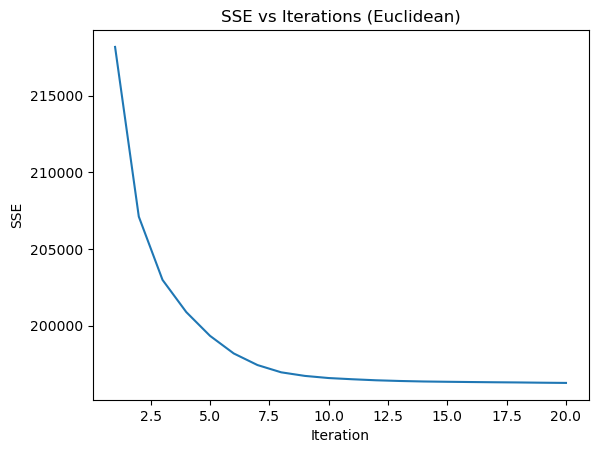

In [151]:
plt.plot(range(1,21), SSE_E)
plt.xlabel("Iteration")
plt.ylabel("SSE")
plt.title("SSE vs Iterations (Euclidean)")
plt.show()


## 2️- Percentage Change after 10 iterations

In [152]:
percent_change_E = (SSE_E[0] - SSE_E[9]) / SSE_E[9]
print("Percentage Change:", percent_change_E * 100)


Percentage Change: 10.988200074648748


## 3️- Accuracy vs Iterations

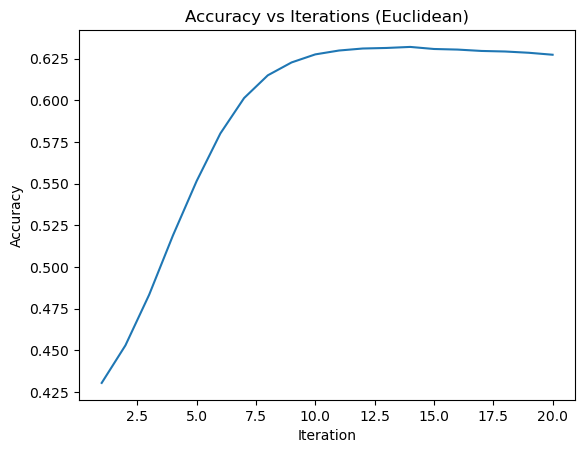

In [153]:
plt.plot(range(1,21), ACC_E)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations (Euclidean)")
plt.show()


## 4️- Silhouette vs Iterations

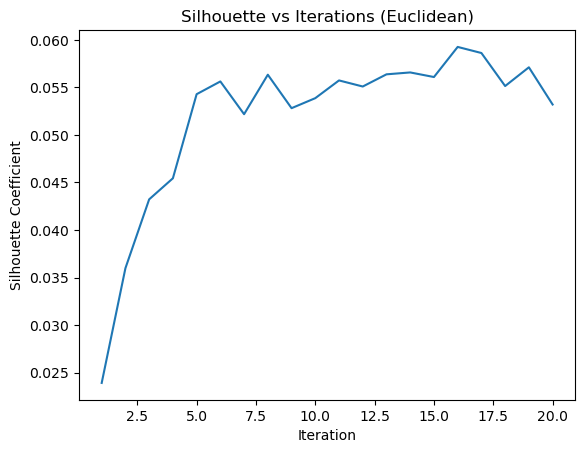

In [154]:
plt.plot(range(1,21), SIL_E)
plt.xlabel("Iteration")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette vs Iterations (Euclidean)")
plt.show()


# Problem B — Cosine Similarity

In [155]:
X_norm = normalize(X)



In [156]:
def kmeans_cosine(X, y, k=10, max_iter=20):
    n = X.shape[0]
    centroids = X[np.random.choice(n, k, replace=False)]

    CSSE, ACC, SIL = [], [], []

    for t in range(max_iter):
        similarities = cosine_similarity(X, centroids)
        labels = np.argmax(similarities, axis=1)

        csse = 0
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster = X[labels == i]
            if len(cluster) > 0:
                new_centroids[i] = cluster.mean(axis=0)
                csse += np.sum(1 - cosine_similarity(cluster, new_centroids[i].reshape(1,-1)))

        centroids = new_centroids
        CSSE.append(csse)

        ACC.append(clustering_accuracy(y, labels, k))

        sample_idx = np.random.choice(n, min(2000, n), replace=False)
        SIL.append(silhouette_score(X[sample_idx], labels[sample_idx]))

    return CSSE, ACC, SIL


In [157]:
CSSE_C, ACC_C, SIL_C = kmeans_cosine(X_norm, y)


##  SSE vs Iterations

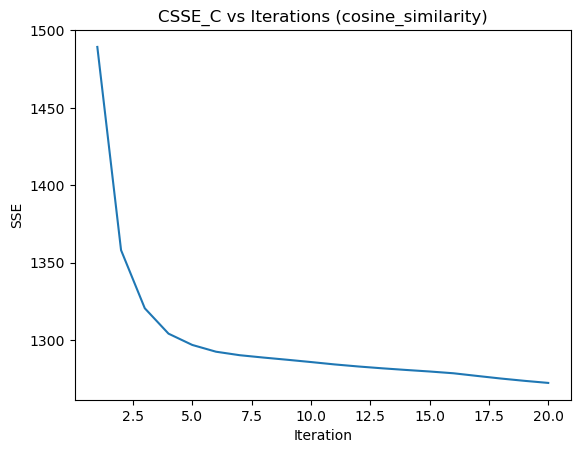

In [158]:
plt.plot(range(1,21), CSSE_C)
plt.xlabel("Iteration")
plt.ylabel("SSE")
plt.title("CSSE_C vs Iterations (cosine_similarity)")
plt.show()


## Accuracy vs Iterations

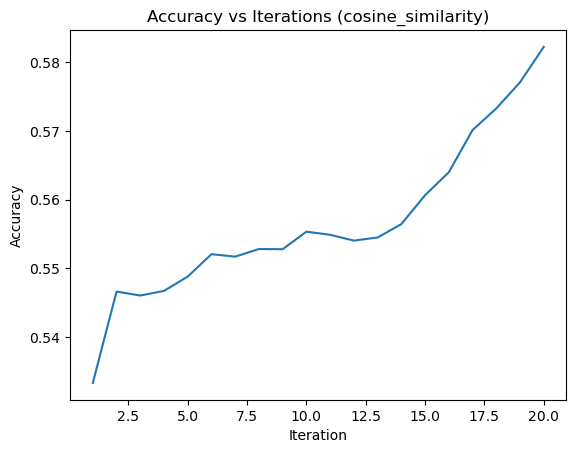

In [159]:
plt.plot(range(1,21), ACC_C)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations (cosine_similarity)")
plt.show()

## Silhouette vs Iterations

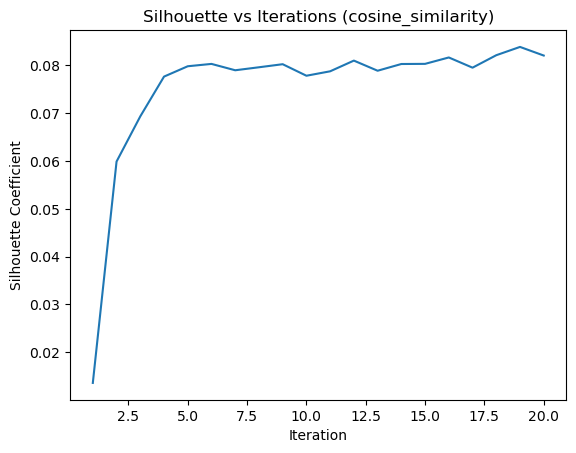

In [160]:
plt.plot(range(1,21), SIL_C)
plt.xlabel("Iteration")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette vs Iterations (cosine_similarity)")
plt.show()


##  Comparison Answer

Euclidean K-Means performs better than cosine similarity K-Means in terms of cost function because MNIST data relies on pixel intensity magnitude, which Euclidean distance preserves, while cosine similarity focuses on direction and ignores magnitude differences.

# Problem C — FIND BEST k (1…40)

In [161]:
def silhouette_vs_k(X, y, distance="euclidean"):
    scores = []
    for k in range(2, 41):
        if distance == "euclidean":
            _, _, sil = kmeans_euclidean(X, y, k=k, max_iter=10)
        else:
            _, _, sil = kmeans_cosine(normalize(X), y, k=k, max_iter=10)
        scores.append(sil[-1])
    return scores


In [162]:
sil_E_k = silhouette_vs_k(X, y, "euclidean")
sil_C_k = silhouette_vs_k(X, y, "cosine")


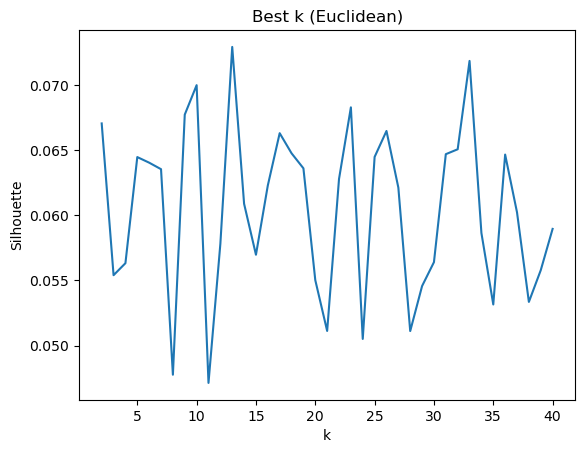

In [163]:
plt.plot(range(2,41), sil_E_k)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Best k (Euclidean)")
plt.show()




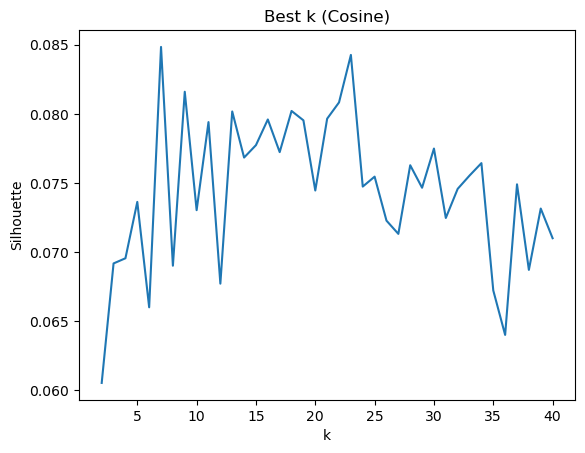

In [164]:
plt.plot(range(2,41), sil_C_k)
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Best k (Cosine)")
plt.show()

## Is best k = 10?
Conclusion:
- For Cosine distance, the best k seems to be slightly lower, maybe 7-8.
- For Euclidean distance, the best k seems to be slightly higher, maybe 12–15, depending on whether you prioritize the absolute silhouette peak or a more stable plateau. 

So the best k is not exactly the same in both distance metrics.